### Data preparation

* Check if the missing values are presented in the features.
* If there are missing values:
    * For caterogiral features, replace them with 'NA'
    * For numerical features, replace with with 0.0 


Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1`

In [15]:
import pandas as pd
import numpy as np
df = pd.read_csv("course_lead_scoring.csv")

In [16]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [17]:
df.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

In [18]:
categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    
    df[c] = df[c].fillna('NA')
df.isnull().sum()   

lead_source                   0
industry                      0
number_of_courses_viewed      0
annual_income               181
employment_status             0
location                      0
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [19]:
categorical_columns

['lead_source', 'industry', 'employment_status', 'location']

In [20]:
df['annual_income'] = df['annual_income'].fillna(0.0)
df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

del df_train['converted']
del df_val['converted']
del df_test['converted']




### Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score (aka prediction) and compute the AUC with the `y` variable as ground truth.
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['balance']`)

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `lead_score`
- `number_of_courses_viewed`
- `interaction_count`
- `annual_income`


In [22]:
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np

features = ['lead_score', 'number_of_courses_viewed', 'interaction_count', 'annual_income']
auc_scores = {}

for feature in features:
    score = df_train[feature]
    auc = roc_auc_score(y_train, score)
    
    # If AUC < 0.5, invert the variable
    if auc < 0.5:
        print("AQUI")
        score = -score
        auc = roc_auc_score(y, score)

    auc_scores[feature] = auc
auc_scores

{'lead_score': 0.6144993577250176,
 'number_of_courses_viewed': 0.7635680590007088,
 'interaction_count': 0.738270176293409,
 'annual_income': 0.5519578313253012}

### ANSWER QUESTION 1: number_of_courses_viewed

### Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.32
- 0.52
- 0.72
- 0.92

In [23]:
dv = DictVectorizer(sparse=False)
numerical_columns=["number_of_courses_viewed","annual_income","interaction_count","lead_score"]
train_dict = df_train[categorical_columns + numerical_columns].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)
###
val_dict = df_val[categorical_columns + numerical_columns].to_dict(orient='records')
X_val = dv.transform(val_dict)
y_pred = model.predict_proba(X_val)[:, 1]
###
round(roc_auc_score(y_val, y_pred), 3)


0.817

### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.145
* 0.345
* 0.545
* 0.745

In [24]:
import numpy as np
from sklearn.metrics import accuracy_score
val_dict = df_val[categorical_columns + numerical_columns].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
scores = []



scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    if t<=0.98:
        score = accuracy_score(y_val, y_pred >= t)
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)
        
        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)
    
        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()
    
        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()
        #print(t,tp,fp)
        #print(t,tp,fn)
        scores.append((t, tp, fp, fn, tn))    
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)        

In [25]:
df_scores[abs(df_scores.r-df_scores.p)<=0.01]

,threshold,tp,fp,fn,tn,p,r
64,0.64,134,38,37,84,0.77907,0.783626


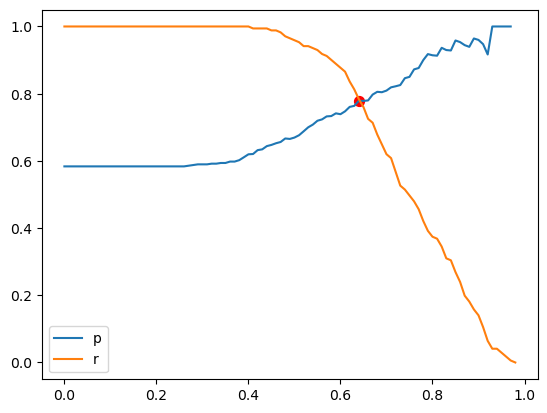

In [26]:
import matplotlib.pyplot as plt
plt.plot(df_scores.threshold, df_scores['p'], label='p')
plt.plot(df_scores.threshold, df_scores['r'], label='r')
plt.scatter(0.64,0.77907,color="red",s=50)
plt.legend()

### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.14
- 0.34
- 0.54
- 0.74

In [27]:

df_scores['F1'] =2*( df_scores.r *df_scores.p )/ (df_scores.r + df_scores.p)
max_f1_row = df_scores.loc[df_scores['F1'].idxmax()]
max_f1_row


threshold      0.570000
tp           156.000000
fp            57.000000
fn            15.000000
tn            65.000000
p              0.732394
r              0.912281
F1             0.812500
Name: 57, dtype: float64

### Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

- 0.0001
- 0.006
- 0.06
- 0.36

In [30]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=1)

auc_scores = []

for train_index, val_index in kf.split(df_full_train):
    df_train, df_val = df_full_train.iloc[train_index], df_full_train.iloc[val_index]
    y_train = df_train.converted.values
    y_val = df_val.converted.values
    del df_train['converted']
    del df_val['converted']
    # Use pipeline to scale + model
    model = make_pipeline(
        StandardScaler(),
        
    )
    model=LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    dv = DictVectorizer(sparse=False)
    train_dict = df_train[categorical_columns + numerical_columns].to_dict(orient='records')
    X_train = dv.fit_transform(train_dict)
    model.fit(X_train, y_train)
    val_dict = df_val[categorical_columns + numerical_columns].to_dict(orient='records')
    X_val = dv.transform(val_dict)
    
    y_pred = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    auc_scores.append(auc)

    print(f'AUC: {round(auc, 3)}')
std_auc = np.std(auc_scores)  
std_auc

AUC: 0.806
AUC: 0.871
AUC: 0.775
AUC: 0.802
AUC: 0.856


np.float64(0.03580711942905165)

### Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.000001, 0.001, 1]`
* Initialize `KFold` with the same parameters as previously
* Use these parameters for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.000001
- 0.001
- 1

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.

In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold

def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical_columns + numerical_columns].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    model = make_pipeline(
    StandardScaler(),
    LogisticRegression(C=1, solver='liblinear', max_iter=1000))
   
    model.fit(X_train, y_train)
    
    return dv, model

def predict(df, dv, model):
    dicts = df[categorical_columns + numerical_columns].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred
   
n_splits = 5
for C in [0.000001, 0.001, 1]:
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.converted.values
        y_val = df_val.converted.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=1e-06 0.920 +- 0.010
C=0.001 0.920 +- 0.010
C=1 0.920 +- 0.010
